# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [135]:
from keras.datasets import cifar100

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [297]:
# Warning Libraries 
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Markdown, display
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.models import Sequential
from keras.utils import to_categorical
from skimage.io import imread
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


In [137]:
Markdown("#### CIFAR-100 dataset\n"
         "- Training data shape: **{}**\n"
         "- Testing data shape: **{}**\n"
         "- Training data labels shape: **{}**\n"
         "- Testing data labels shape: **{}**".format(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
         )

#### CIFAR-100 dataset
- Training data shape: **(50000, 32, 32, 3)**
- Testing data shape: **(10000, 32, 32, 3)**
- Training data labels shape: **(50000, 1)**
- Testing data labels shape: **(10000, 1)**

In [138]:
pd.DataFrame(x_train[0,:,:,0]).head(10)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,252,242,229,195,212,182
1,255,254,254,254,254,254,254,254,254,254,...,255,253,253,252,247,216,198,170,161,146
2,255,254,255,255,255,255,255,255,255,255,...,235,250,255,253,246,220,193,189,166,121
3,255,254,255,255,255,255,255,253,252,248,...,185,243,250,231,224,212,192,167,149,120
4,255,254,255,255,255,255,255,253,232,210,...,144,242,242,214,180,157,176,157,144,126
5,255,254,255,255,255,255,255,252,213,210,...,43,169,230,193,133,126,146,156,154,157
6,255,254,255,255,255,255,255,254,225,204,...,15,78,141,131,142,140,139,177,179,171
7,255,254,255,255,255,255,255,253,249,220,...,28,48,86,123,137,121,134,152,166,172
8,255,255,254,254,255,255,255,254,254,247,...,27,38,93,121,114,118,135,105,90,115
9,253,255,252,244,250,253,255,254,250,212,...,33,51,104,106,117,117,107,102,84,50


In [139]:
import json
labels = open('cifar-100-labels.json', 'r')
labels = json.load(labels)


joined_labels = [labels[i[0]] for i in y_train]
pd.DataFrame(joined_labels, columns=['Label'])


,Label
0,cattle
1,dinosaur
2,apple
3,boy
4,aquarium_fish
...,...
49995,squirrel
49996,beetle
49997,bear
49998,beetle


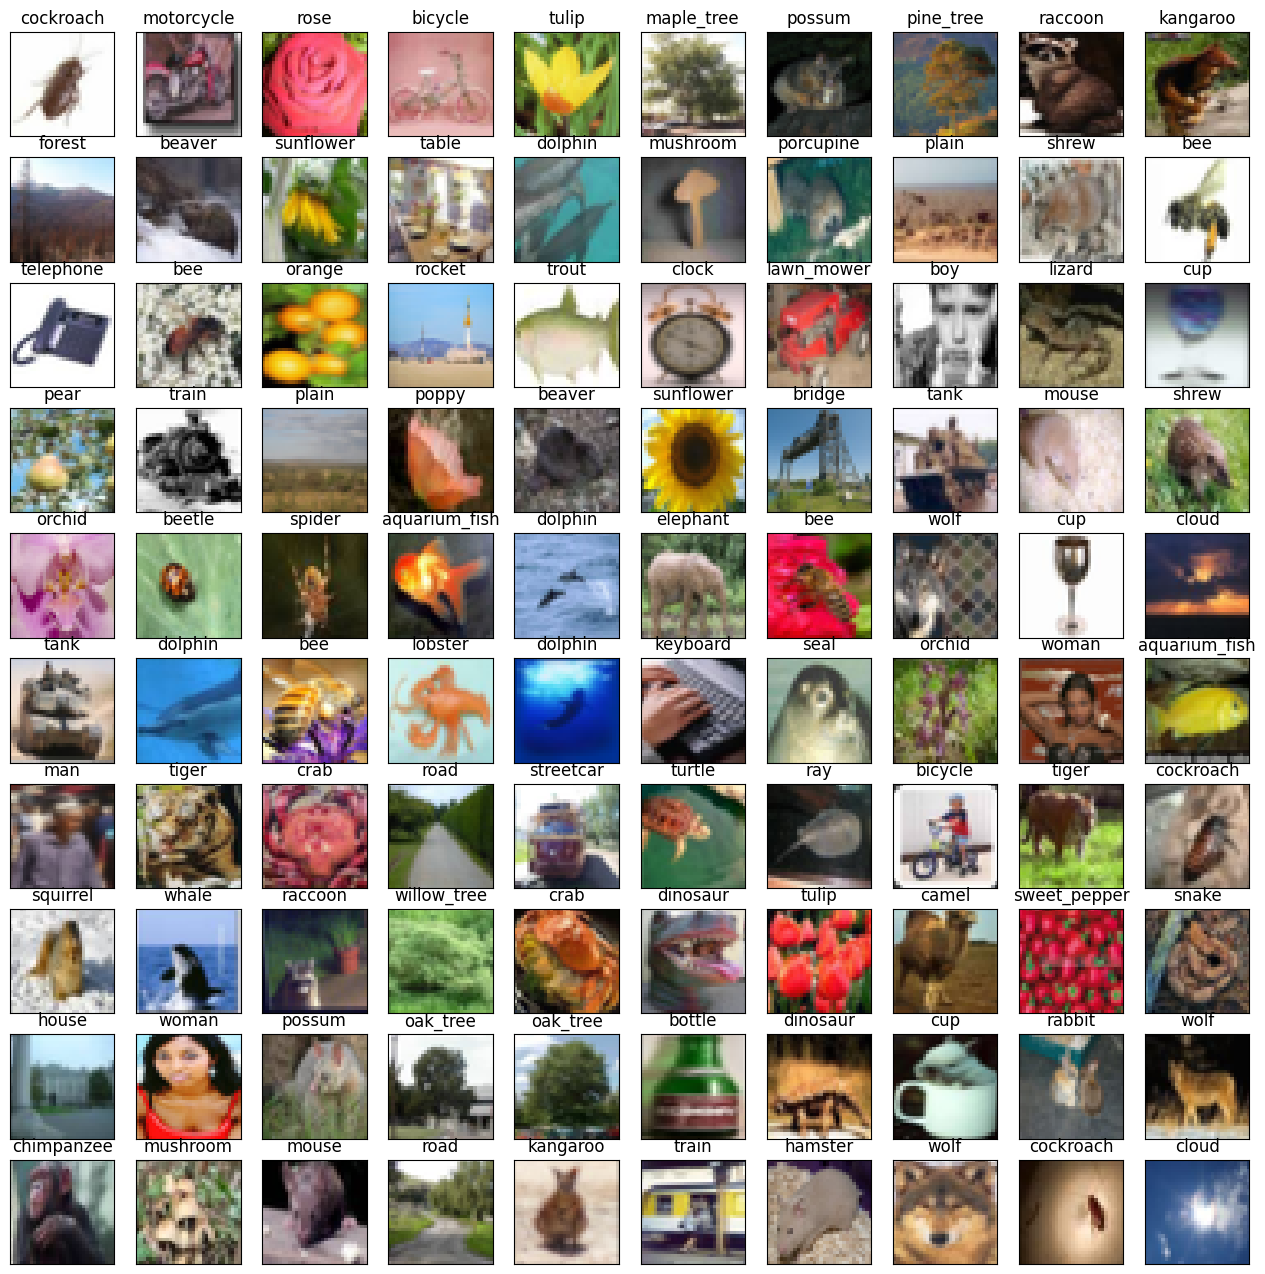

In [140]:

random_indices = np.random.choice(len(x_train), 100, replace=False)

# Creating a grid plot
fig, axes = plt.subplots(10, 10, figsize=(16, 16))

for i, ax in enumerate(axes.flat):
    image = x_train[random_indices[i]].astype(np.uint8)/255.0
    ax.set_title(f"{joined_labels[random_indices[i]]}")
    ax.imshow(image)

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [158]:
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

y_train_one_hot = to_categorical(y_train, 100)
y_test_one_hot = to_categorical(y_test, 100)

x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    x_train_normalized, 
    y_train_one_hot,
    test_size=0.2, # 20% of the data is used for testing
    random_state=42 # Providing a value here means getting the same "random" split every time
)

pd.DataFrame(y_train_split).head(20)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [274]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='softmax'))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,932 (1019.27 KB)

 Trainable params: 260,932 (1019.27 KB)

 Non-trainable params: 0 (0.00 B)

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different. 
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> Categorical_crossentropy is indicated for class classification problems when using one-hot encoded labels.
- <b>Optimizer:</b> Adam is usually a general good choice due on how it optimizes the learning rate. 

In [275]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [276]:
history = model.fit(
    x_train_split, y_train_split,
    epochs=30,  
    batch_size=32,
    # validation_split=0.2 # Use 20% of the data for validation
    validation_data=(x_test_split, y_test_split)
)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0373 - loss: 4.3416 - val_accuracy: 0.1147 - val_loss: 3.7598
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1306 - loss: 3.6715 - val_accuracy: 0.1728 - val_loss: 3.4045
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1808 - loss: 3.3808 - val_accuracy: 0.2142 - val_loss: 3.2085
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2161 - loss: 3.1808 - val_accuracy: 0.2307 - val_loss: 3.1231
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2492 - loss: 3.0162 - val_accuracy: 0.2533 - val_loss: 3.0242
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2679 - loss: 2.8814 - val_accuracy: 0.2583 - val_loss: 2.9816
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2950 - loss: 2.7762 - val_accuracy: 0.2835 - val_loss: 2.8711
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3099 - loss: 2.6795 - 

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> 0.32
- <b>Other metric:</b> precision
- <b>Reason for selection:</b> Understand how well the model behaves when trying to predict a specific class.
- <b>Value of metric:</b> 0.3319
- <b>Interpretation of metric value:</b> Large variation between some classes, where some can be identified relatively well, like *chair* (0.6) but others like *seal* (0.1) are mostly misclassified.

In [277]:

test_loss, test_acc = model.evaluate(x_test_normalized, y_test_one_hot, verbose=1)

y_test_pred = model.predict(x_test_normalized)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test_one_hot, axis=1)

# Classification report
precision = precision_score(y_test_true_labels, y_test_pred_labels, average='weighted')
report = classification_report(y_test_true_labels, y_test_pred_labels, target_names=labels)
print("Classification Report:\n", report)
print("Precision Score: {:.4f}".format(precision))


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.3254 - loss: 3.1270
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
                precision    recall  f1-score   support

        apple       0.55      0.65      0.60       100
aquarium_fish       0.37      0.52      0.43       100
         baby       0.21      0.16      0.18       100
         bear       0.18      0.13      0.15       100
       beaver       0.18      0.22      0.20       100
          bed       0.20      0.30      0.24       100
          bee       0.30      0.41      0.35       100
       beetle       0.37      0.41      0.39       100
      bicycle       0.27      0.32      0.29       100
       bottle       0.53      0.38      0.44       100
         bowl       0.22      0.15      0.18       100
          boy       0.20      0.20      0.20       100
       bridge       0.44      0.28      0.34       100
          bus       0.25      0.31      0.28       100
    butterfly       0.27      0.

### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

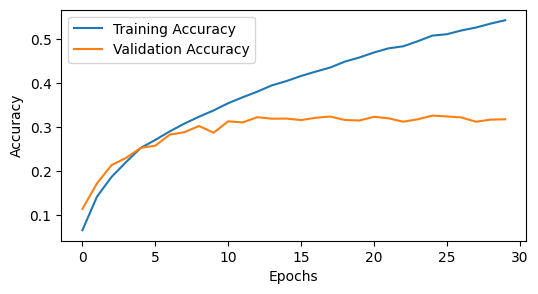

In [278]:
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

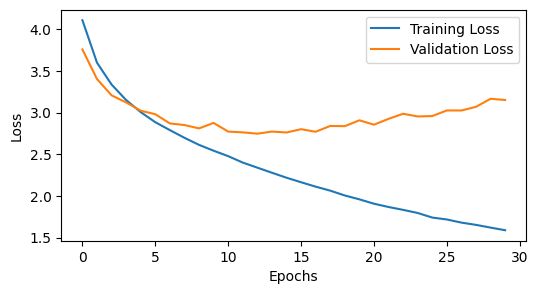

In [279]:
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

True label: **20**  
Predicted label: **20**  
Probability: **0.9981430768966675**

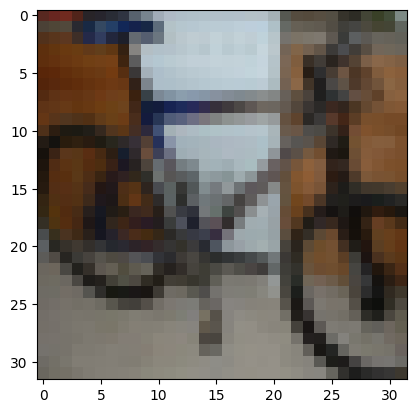

In [281]:
# Correct image
correct_img_index = 30

plt.imshow(x_train_normalized[correct_img_index])

pred_label = y_test_pred_labels[correct_img_index]
true_label = y_test_true_labels[correct_img_index]

Markdown(f"True label: **{true_label}**  \n"
         f"Predicted label: **{pred_label}**  \n"
        f"Probability: **{y_test_pred[correct_img_index][pred_label]}**"
         )

True label: **18**  
Predicted label: **88**  
Probability: **2.8325758405500778e-11**

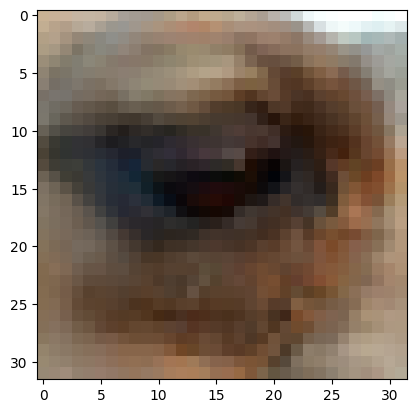

In [280]:
# Incorrect image
incorrect_img_index = 91

plt.imshow(x_train_normalized[incorrect_img_index])

pred_label = y_test_pred_labels[incorrect_img_index]
true_label = y_test_true_labels[incorrect_img_index]

Markdown(f"True label: **{true_label}**  \n"
         f"Predicted label: **{pred_label}**  \n"
        f"Probability: **{y_test_pred[correct_img_index][pred_label]}**"
         )

The model displays some limited generalization capabilities which seems to saturate around 15 epochs.

## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [304]:
model = Sequential()
model.add(Conv2D(32, (3, 3) ,input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='softmax'))
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_82 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_68 (Activation)      │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_69 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_70 (Activation)      │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_71 (Activation)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_72 (Activation)      │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_73 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 8, 8, 128)      │             

 Total params: 4,640,644 (17.70 MB)

 Trainable params: 4,639,748 (17.70 MB)

 Non-trainable params: 896 (3.50 KB)

In [305]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train_split, y_train_split,
    epochs=30,  
    batch_size=32,
    # validation_split=0.2 # Use 20% of the data for validation
    validation_data=(x_test_split, y_test_split)
)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0490 - loss: 4.3608 - val_accuracy: 0.0971 - val_loss: 3.8846
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1225 - loss: 3.7144 - val_accuracy: 0.1614 - val_loss: 3.5460
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1771 - loss: 3.4078 - val_accuracy: 0.1637 - val_loss: 3.5969
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2265 - loss: 3.1525 - val_accuracy: 0.2418 - val_loss: 3.0776
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2639 - loss: 2.9359 - val_accuracy: 0.2747 - val_loss: 2.8942
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3008 - loss: 2.7352 - val_accuracy: 0.3221 - val_loss: 2.6700
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3361 - loss: 2.5579 - val_accuracy: 0.3406 - val_loss: 2.5612
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3717 - loss: 2.3906 -

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

In [306]:
test_loss, test_acc = model.evaluate(x_test_normalized, y_test_one_hot, verbose=1)

y_test_pred = model.predict(x_test_normalized)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test_one_hot, axis=1)

# Classification report
precision = precision_score(y_test_true_labels, y_test_pred_labels, average='weighted')
report = classification_report(y_test_true_labels, y_test_pred_labels, target_names=labels)
print("Classification Report:\n", report)
print("Precision Score: {:.4f}".format(precision))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3846 - loss: 3.4443
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Classification Report:
                precision    recall  f1-score   support

        apple       0.44      0.78      0.57       100
aquarium_fish       0.48      0.42      0.45       100
         baby       0.32      0.25      0.28       100
         bear       0.19      0.17      0.18       100
       beaver       0.14      0.10      0.11       100
          bed       0.26      0.28      0.27       100
          bee       0.44      0.41      0.42       100
       beetle       0.38      0.43      0.41       100
      bicycle       0.47      0.46      0.47       100
       bottle       0.62      0.48      0.54       100
         bowl       0.25      0.20      0.22       100
          boy       0.27      0.22      0.24       100
       bridge       0.34      0.31      0.33       100
          bus       0.37      0.29      0.32       100
    butterfly       0.35      0.25

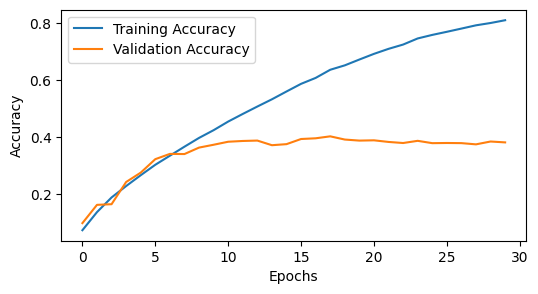

In [307]:
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

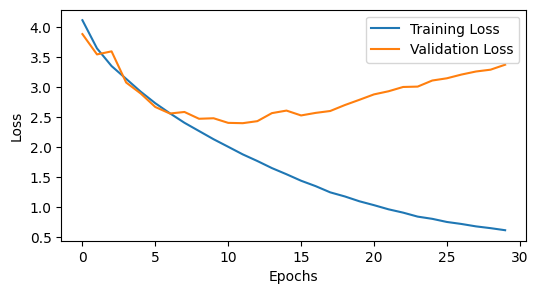

In [308]:
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

True label: **54**  
Predicted label: **54**  
Probability: **0.9998279809951782**

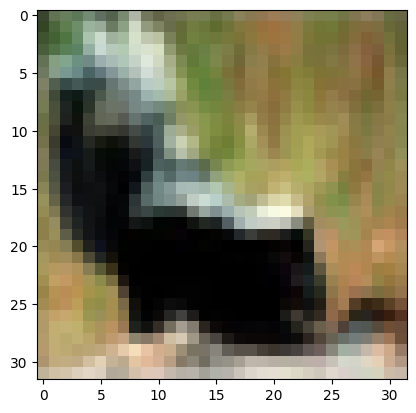

In [314]:
# Correct image
correct_img_index = 82

plt.imshow(x_train_normalized[correct_img_index])

pred_label = y_test_pred_labels[correct_img_index]
true_label = y_test_true_labels[correct_img_index]

Markdown(f"True label: **{true_label}**  \n"
         f"Predicted label: **{pred_label}**  \n"
        f"Probability: **{y_test_pred[correct_img_index][pred_label]}**"
         )

In [ ]:
# Incorrect image
incorrect_img_index = 232

plt.imshow(x_train_normalized[incorrect_img_index])

pred_label = y_test_pred_labels[incorrect_img_index]
true_label = y_test_true_labels[incorrect_img_index]

Markdown(f"True label: **{true_label}**  \n"
         f"Predicted label: **{pred_label}**  \n"
        f"Probability: **{y_test_pred[correct_img_index][pred_label]}**"
         )

### Task 4c: Discussion of the results

- Briefly discuss the results. 
- Did the model's performance improve? 
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here

Yes, the model performance improve. It wasn't a significant improvement - from 32% to 39% accuracy, but
the extra layers seem to help.

The added new layers can likely accomodate more complex image patterns, allowing the model to 
recognize more image classes.

Definitely there is for improvement. Compared to models like ResNet, this one is quite simple, 
so starting with a more complex and sophiscated model would be very beneficial here.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.